In [32]:
# Libraries import
import pandas as pd
from io import StringIO
import numpy as np
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

During loading data, I encountered issue with too many commas in some lines, therefore I clean double commas and commas on the end of the line, if there is more than 13 values in the row.

In [3]:
# Data load
# Open the file and clean commas
cleaned_lines = []
with open("modelowanie_pricing_EH.csv", "r") as f:
    for line in f:
        if len(line.split(",")) == 13:
            cleaned_lines.append(line)
        else:
            cleaned_lines.append(line.replace(",,",",").rstrip(",\n"))

# Convert cleaned data into a StringIO object for pandas
cleaned_csv = StringIO("\n".join(cleaned_lines))

# Read into pandas
df_freq = pd.read_csv(cleaned_csv, index_col=0)

In [4]:
# Data overview
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,NaN,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [5]:
# Data details
df_freq.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678012.000000,678012.000000,678012.000000,678012.000000,678012.000000,678012.000000,678012.000000
mean,2.621857e+06,0.053245,0.528749,6.454632,7.044251,45.499102,59.761506,1792.420280
std,1.641783e+06,0.240115,0.364441,2.050907,5.666225,14.137445,15.636669,3958.649096
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [6]:
# creating lists of numerical and categorical features
numerical = ["ClaimNb", "Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
categorical = ["Area", "VehBrand", "VehGas", "Region"]

In [7]:
# checking proportio of categories in all categorical features
for col in categorical:
    aggregated = (
        df_freq.groupby(col)["IDpol"]
        .agg(count="count")
        .reset_index()
        .assign(share=lambda x: round(100 * x["count"] / len(df_freq), 2))
    )
    
    print("\n", tabulate(aggregated, headers="keys"))


     Area      count    share
--  ------  -------  -------
 0  A        103957    15.33
 1  B         75458    11.13
 2  C        191880    28.3
 3  D        151596    22.36
 4  E        137167    20.23
 5  F         17954     2.65

     VehBrand      count    share
--  ----------  -------  -------
 0  B1           162736    24
 1  B10           17707     2.61
 2  B11           13585     2
 3  B12          166023    24.49
 4  B13           12178     1.8
 5  B14            4047     0.6
 6  B2           159861    23.58
 7  B3            53395     7.88
 8  B4            25179     3.71
 9  B5            34753     5.13
10  B6            28548     4.21

     VehGas      count    share
--  --------  -------  -------
 0  Diesel     332135    48.99
 1  Regular    345877    51.01

     Region      count    share
--  --------  -------  -------
 0  R11         69790    10.29
 1  R21          3026     0.45
 2  R22          7994     1.18
 3  R23          8784     1.3
 4  R24        160600    23.69


Dataset contains 12 features of which:
 - one is a key of a row, doesn't have any predictive value and it will be removed
 - 7 are numerical
 - 4 are cathegorical

All numerical values seems to be very right skewed, what will impact outliers analysis. On the other hand both min and max values looks reasonable and logical, with the exeption of viehal and driver age where values of 100 seems a little suspicious, but it will be explored in more details leter on. Cathegorical values are mostly unevenlly distributed among categories.

In [8]:
# removing IDpol
df_freq.drop('IDpol', axis=1, inplace=True)

In [9]:
# null values overview
df_freq.isnull().sum()

ClaimNb       1
Exposure      1
Area          1
VehPower      1
VehAge        1
DrivAge       1
BonusMalus    1
VehBrand      1
VehGas        1
Density       1
Region        1
dtype: int64

In [10]:
# details of null values
df_freq[df_freq.isnull().any(axis=1)]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
3,1.0,0.09,NaN,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
567,NaN,0.85,C,7.0,0.0,45.0,50.0,B12,Regular,309.0,R73
32341,0.0,0.32,C,7.0,11.0,47.0,72.0,B2,NaN,168.0,R91
45732,0.0,1.00,A,NaN,1.0,50.0,50.0,B3,Diesel,15.0,R24
71923,0.0,1.00,C,4.0,8.0,67.0,50.0,B5,Regular,432.0,NaN
84919,0.0,1.00,C,5.0,5.0,30.0,NaN,B1,Diesel,163.0,R24
99992,0.0,1.00,E,6.0,6.0,64.0,50.0,B2,Diesel,NaN,R82
173492,0.0,NaN,A,5.0,7.0,33.0,50.0,B13,Diesel,31.0,R24
184622,0.0,0.50,A,9.0,NaN,47.0,79.0,B5,Regular,7.0,R93
184711,1.0,0.50,D,7.0,10.0,NaN,50.0,B2,Regular,1440.0,R93


There are 11 rows with null values in dataset, which is approximatelly 0.0016% of the whole dataset. Pottential solution is to use some imputation method like KNNImputer or replacing those values with median. However, this amount of data won't have much impact on training model, therefore I will simply delete this data.

In [11]:
# droping null values
df_freq.dropna(inplace=True)
df_freq.reset_index(drop=True, inplace=True)
df_freq[df_freq.isnull().any(axis=1)]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region


In [12]:
# explorying outliers
def find_outliers(df: pd.DataFrame, threshold=1.5, method="IQR"):
    '''
    detects numerical outliers in a DataFrame using either Interquartile Range or Z-score methods. 
    It prints a summary of detected outliers for each numeric column.

    df (pd.DataFrame):  DataFrame, in which otliers 
    threshold (float, default=1.5): Multiplier for IQR or standard deviations for Z-score.
    method (str, default="IQR"): Outlier detection method ("IQR" or "z_score").
    '''

    # select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])

    # declaration of rows for summary
    results = {
        "Bounds (Min / Max)": [],
        "Total Outliers": [],
        "Share of outliers [%]": [],
        "Upper Bound Outliers": [],
        "Lower Bound Outliers": []
    }

    # caluculating otliers based on choosen method
    if method == "IQR":
        q1s = numeric_df.quantile(0.25)
        q3s = numeric_df.quantile(0.75)
        IQRs = q3s - q1s

        min_bounds = q1s - threshold * IQRs
        max_bounds = q3s + threshold * IQRs
    elif method == "z_score":
        means = numeric_df.mean()
        stds = numeric_df.std()
        
        min_bounds = means - threshold * stds
        max_bounds = means + threshold * stds
    else:
        raise ValueError("valid method values are: [IQR, z_score]")

    # filling summary frame
    column_names = []
    for col in numeric_df.columns:
        min_bond = min_bounds[col]
        max_bond = max_bounds[col]

        outliers = numeric_df[col]
        outliers_mask = (outliers < min_bond) | (outliers > max_bond)
        outliers_count = outliers_mask.sum()

        column_names.append(col)
        results["Bounds (Min / Max)"].append(f"{min_bond:.3f} / {max_bond:.3f}")
        results["Total Outliers"].append(outliers_count)
        results["Share of outliers [%]"].append(round(100*outliers_count/df.shape[0],2))
        results["Upper Bound Outliers"].append((outliers > max_bond).sum())
        results["Lower Bound Outliers"].append((outliers < min_bond).sum())

    # printing summary of outliers if any
    if results["Total Outliers"]:
        df_results = pd.DataFrame(results, index=column_names).T
        print(tabulate(df_results, headers="keys"))
    else:
        print("No outliers found.")

In [13]:
# finding outliers
find_outliers(df_freq)
print("\n")
find_outliers(df_freq, threshold=2, method="z_score")

                       ClaimNb        Exposure        VehPower        VehAge            DrivAge         BonusMalus       Density
---------------------  -------------  --------------  --------------  ----------------  --------------  ---------------  --------------------
Bounds (Min / Max)     0.000 / 0.000  -1.035 / 2.205  2.000 / 10.000  -11.500 / 24.500  2.500 / 86.500  29.000 / 85.000  -2257.000 / 4007.000
Total Outliers         34057          0               35071           3114              1275            62384            77566
Share of outliers [%]  5.02           0.0             5.17            0.46              0.19            9.2              11.44
Upper Bound Outliers   34057          0               35071           3114              1275            62384            77566
Lower Bound Outliers   0              0               0               0                 0               0                0


                       ClaimNb         Exposure        VehPower        VehAge    

Depending on the method, the number of observations classified as outliers varies but is generally significant. However, if the values fall within a logical range, they may reflect the characteristic distribution of features in the dataset. Therefore, further exploration is needed before addressing the issue.

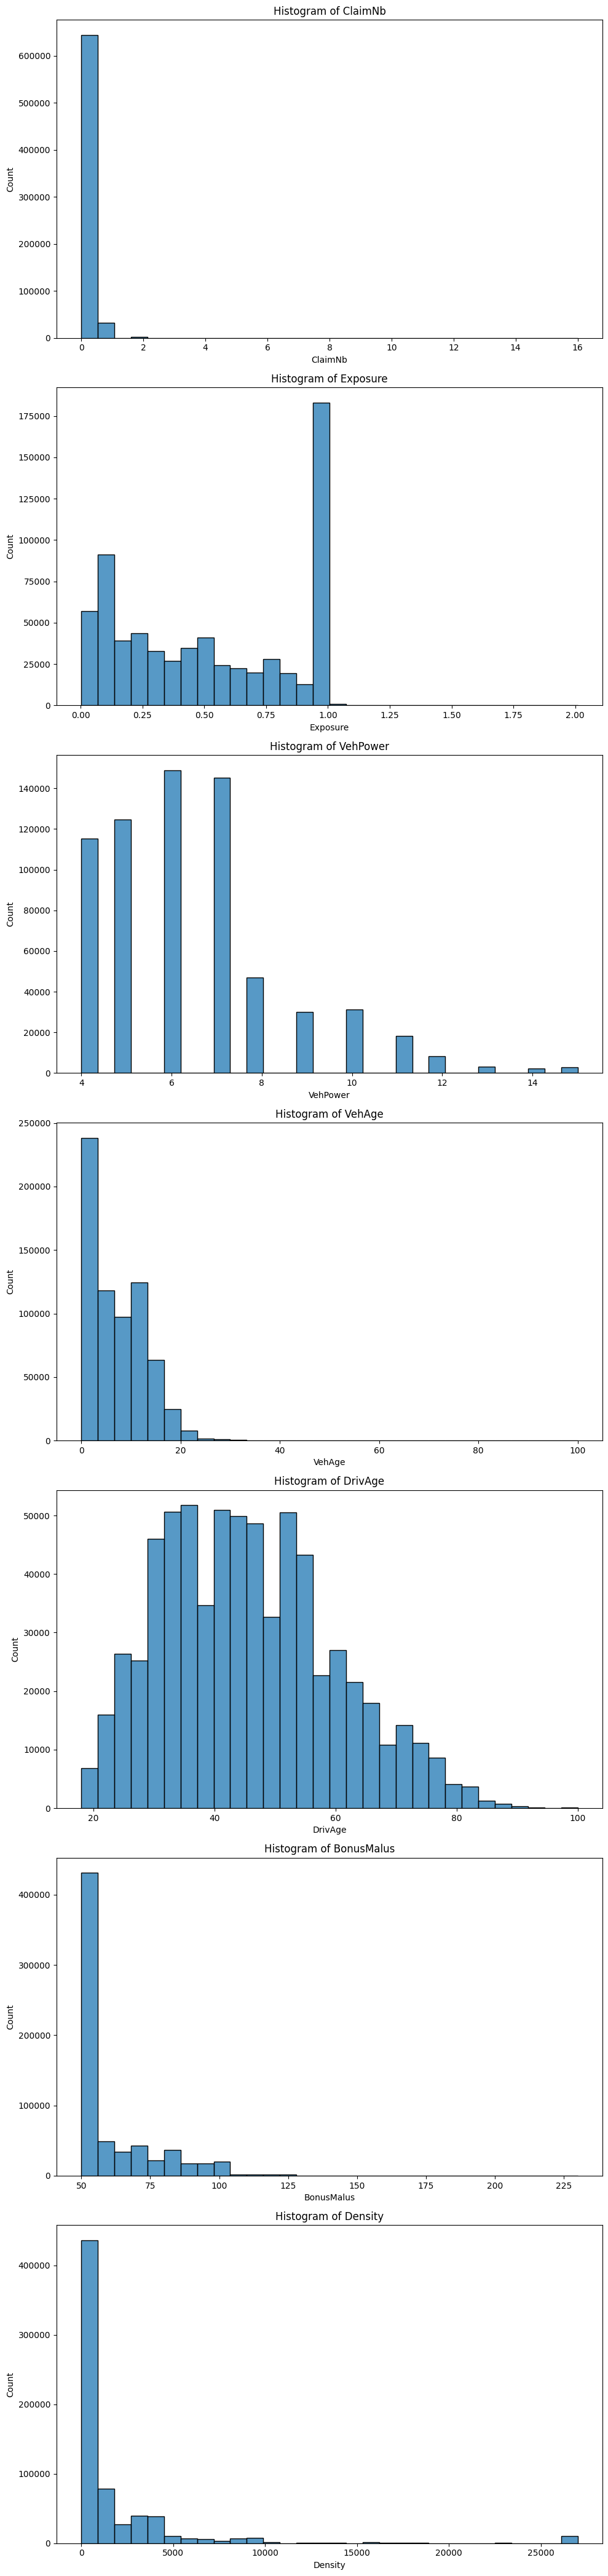

In [ ]:
# display histograms for each numerical feature
plt.figure(figsize=(10, 6 * len(numerical)))

for i, col in enumerate(numerical):
    plt.subplot(len(numerical), 1, i + 1)
    sns.histplot(data=df_freq, x=col, bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    
plt.tight_layout()
plt.show()

In [22]:
# number of vehicals at given age
df_freq[df_freq["VehAge"] > 24.5].groupby("VehAge")["VehAge"].count()

VehAge
25.0     495
26.0     369
27.0     326
28.0     278
29.0     281
30.0     249
31.0     217
32.0     153
33.0     124
34.0     103
35.0      94
36.0      71
37.0      47
38.0      36
39.0      25
40.0      16
41.0       8
42.0      13
43.0      15
44.0      15
45.0      12
46.0      19
47.0      14
48.0      17
49.0      12
50.0       8
51.0       4
52.0       6
53.0       2
54.0       2
55.0       1
59.0       2
60.0       1
62.0       1
63.0       1
64.0       1
65.0       2
66.0       2
68.0       2
69.0       4
70.0       3
71.0       1
76.0       1
78.0       1
79.0       1
80.0       3
81.0       3
82.0       1
83.0       2
84.0       1
85.0       1
99.0      23
100.0     25
Name: VehAge, dtype: int64

In [23]:
# number of peolpe at given age
df_freq[df_freq["DrivAge"] > 86.5].groupby("DrivAge")["DrivAge"].count()

DrivAge
87.0     280
88.0     229
89.0     198
90.0     167
91.0     121
92.0      66
93.0      55
94.0      32
95.0      24
96.0      15
97.0      10
98.0       5
99.0      70
100.0      3
Name: DrivAge, dtype: int64

There are a few values that can be classified as outliers in both driver and vehicle age, based on quantitative methods and real-world knowledge. Therefore, I will treat them as outliers and impute these values using an appropriate imputation method.

In [24]:
# checking areas and regions diversity for highest density
area_var = ["Area", "Region"]
for col in area_var:
    print(df_freq[df_freq["Density"] >= 27000][col].unique())

['F']
['R11']


In [26]:
# checking density diversity for Area and Region with highest density
df_freq[(df_freq["Area"] == "F") & (df_freq["Region"] == "R11")]\
    .groupby("Density")["Density"]\
    .count()\
    .sort_values(ascending=False)

Density
27000.0    10515
17140.0      910
10156.0      816
16533.0      613
15703.0      557
15725.0      526
22669.0      463
10477.0      344
12374.0      296
14368.0      285
12750.0      225
10155.0      202
18229.0      200
16284.0      194
22821.0      182
16291.0      175
10068.0      171
10961.0      165
13520.0      158
12650.0      154
15386.0      145
10008.0      144
13719.0      119
14200.0      109
21410.0       76
12437.0       70
16052.0       68
23396.0       66
20000.0        6
Name: Density, dtype: int64

Density of 27000 looks a little odd but there is no bases to address tis value since it occures only in Region 11, area F and is also the most frequent value of density in this place.

In [27]:
# explorying claim number distribution
df_freq[df_freq["ClaimNb"] > 0].groupby("ClaimNb").agg({"ClaimNb":"count", "Exposure":"mean"})

,ClaimNb,Exposure
ClaimNb,,
1.0,32175,0.642403
2.0,1784,0.646535
3.0,82,0.643415
4.0,7,0.438571
5.0,2,0.540000
6.0,1,0.330000
8.0,1,0.410000
9.0,1,0.080000
11.0,3,0.383333


In [28]:
df_freq[df_freq["ClaimNb"].isin([9, 11, 16])]

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
6537,11.0,1.00,A,5.0,6.0,65.0,50.0,B2,Diesel,13.0,R24
321238,16.0,0.33,D,4.0,12.0,52.0,50.0,B1,Regular,824.0,R91
321502,9.0,0.08,D,4.0,12.0,52.0,50.0,B1,Regular,824.0,R91
487258,11.0,0.08,D,4.0,13.0,53.0,50.0,B1,Regular,824.0,R91
488260,11.0,0.07,D,4.0,13.0,53.0,50.0,B1,Regular,824.0,R91


The top values of claim number looks very suspicious especially taking into consideration exposure period. For example it is very unlikelly to have 9 claims in a month.

Clearying outliers strategy:
- for driver age and vehical age I will delete values above 25 and 87 and impute them with KNN algorithm.
- for claim number I cannot use the same strategy, as there is very little obserwtions with claims. Therefore I will set a cap of claims to 5 and change anything above 5 to 5. There is no point in training seperate imputer as there is only 7 observations above 5.

In [29]:
df_freq["DrivAge"] = df_freq["DrivAge"].where(~(df_freq["DrivAge"] > 87), np.nan)
df_freq["VehAge"] = df_freq["VehAge"].where(~(df_freq["VehAge"] > 25), np.nan)

In [33]:
# encoding and scaling categorical variables for the purpose of imputation
to_encode = df_freq[categorical]

ohe = OneHotEncoder(sparse_output=False, drop="first")

encoded_array = ohe.fit_transform(to_encode)
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(to_encode.columns))
df_final = pd.concat([df_freq[numerical], encoded_df], axis=1)

scaler = StandardScaler()
df_final[numerical] = scaler.fit_transform(df_final[numerical])

df_final

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_B,Area_C,Area_D,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,3.943000,-1.176453,-0.709264,-1.286082,0.681462,-0.624273,-0.145363,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.943000,0.661979,-0.709264,-1.286082,0.681462,-0.624273,-0.145363,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3.943000,0.607100,-0.221676,-0.915708,0.467785,-0.624273,-0.439148,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.943000,0.854054,0.265912,-1.286082,0.040430,-0.624273,-0.433591,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.943000,-0.024003,-0.221676,-0.915708,-0.529377,-0.624273,0.305799,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677997,-0.221744,-1.443328,-1.196852,-1.286082,0.610237,-0.624273,0.385118,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
677998,-0.221744,-1.443328,-1.196852,-1.286082,-0.315700,2.253570,2.035420,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677999,-0.221744,-1.443328,-0.221676,-0.915708,-0.030796,-0.624273,-0.118586,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
678000,-0.221744,-1.443328,-1.196852,-1.286082,1.037592,-0.624273,-0.428791,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Training imputer and saving results
%%script false
imputer_age = KNNImputer()
imputed_array = imputer_age.fit_transform(df_final)
with open('imputed_array_age.npy', "wb") as f:
    np.save(f, imputed_array)

In [35]:
# Loading results of imputation model and reversing transformations: encoding and scaling
with open("imputed_array_age.npy", "rb") as f:
    imputed_array = np.load('imputed_array_age.npy')

df_full = pd.DataFrame(imputed_array, columns=df_final.columns)
decoded_array = ohe.inverse_transform(df_full[encoded_df.columns])
decoded_df = pd.DataFrame(decoded_array, columns=categorical)
df_full[numerical] = scaler.inverse_transform(df_full[numerical])
df_full = pd.concat([df_full[numerical], decoded_df], axis=1)

df_full

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region
0,1.0,0.10000,5.0,0.0,55.0,50.0,1217.0,D,B12,Regular,R82
1,1.0,0.77000,5.0,0.0,55.0,50.0,1217.0,D,B12,Regular,R82
2,1.0,0.75000,6.0,2.0,52.0,50.0,54.0,B,B12,Diesel,R22
3,1.0,0.84000,7.0,0.0,46.0,50.0,76.0,B,B12,Diesel,R72
4,1.0,0.52000,6.0,2.0,38.0,50.0,3003.0,E,B12,Regular,R31
...,...,...,...,...,...,...,...,...,...,...,...
677997,0.0,0.00274,4.0,0.0,54.0,50.0,3317.0,E,B12,Regular,R93
677998,0.0,0.00274,4.0,0.0,41.0,95.0,9850.0,E,B12,Regular,R11
677999,0.0,0.00274,6.0,2.0,45.0,50.0,1323.0,D,B12,Diesel,R82
678000,0.0,0.00274,4.0,0.0,60.0,50.0,95.0,B,B12,Regular,R26


In [36]:
# adding cap on claim numbers
df_full["ClaimNb"] = df_full["ClaimNb"].where(~(df_full["ClaimNb"] > 5), 5)

In [ ]:
# Creating claim frequency feature
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"]

In [39]:
# after cleaning data exploration
df_full.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimFrequency
count,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000,678002.000000
mean,0.053189,0.528748,6.454637,6.956274,45.442614,59.761574,1792.442657,0.263563
std,0.238196,0.364441,2.050914,5.398479,14.037434,15.636724,3958.673690,4.586582
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000
max,5.000000,2.010000,15.000000,25.000000,87.000000,230.000000,27000.000000,732.000000


After cleaning the data and adding the claim frequency feature, the dataset is much closer to what we expect before exploratory data analysis. However, the maximum claim frequency value of 732 seems incorrect and requires further investigation for a better understanding.

In [41]:
# checking details of exposure for frequency higher than available claim number
df_full[df_full["ClaimFrequency"] > 5]["Exposure"].describe()

count    5471.000000
mean        0.101990
std         0.069547
min         0.002732
25%         0.050000
50%         0.090000
75%         0.140000
max         0.570000
Name: Exposure, dtype: float64

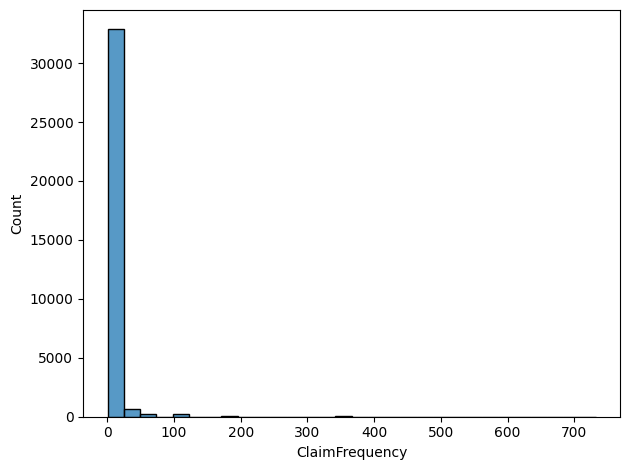

In [45]:
# histogram of claim freqency above 0
sns.histplot(data=df_full[df_full["ClaimFrequency"] > 0], x="ClaimFrequency", bins=30)
plt.tight_layout()
plt.show()

Claim frequencies in the hundreds are suspicious and highly unlikely. The reason for their occurrence is likely a claim during a very short exposure period. To make these values more realistic, I will change the denominator of the claim frequency to 1 (the median) for cases where the exposure period is below a quarter (0.25).

In [ ]:
# claim frequency recalculation
df_full["ClaimFrequency"] = df_full["ClaimNb"]/df_full["Exposure"].apply(lambda x: x if x >= 0.25 else 1)

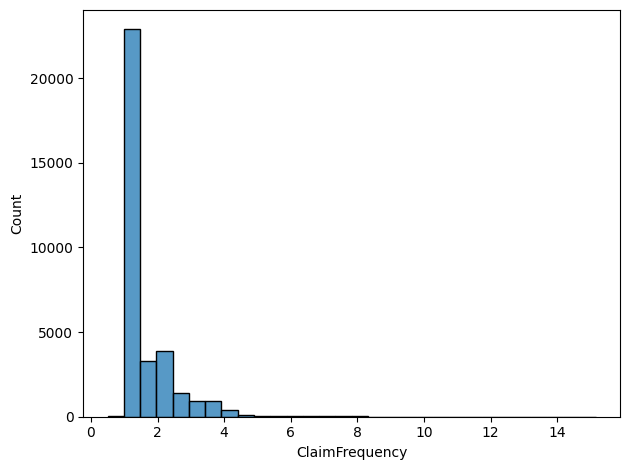

In [47]:
sns.histplot(data=df_full[df_full["ClaimFrequency"] > 0], x="ClaimFrequency", bins=30)
plt.tight_layout()
plt.show()

In [48]:
# explorying highest values of claim frequency
df_full[df_full["ClaimFrequency"] > 14]

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,Area,VehBrand,VehGas,Region,ClaimFrequency
304474,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
321238,5.0,0.33,4.0,12.0,52.0,50.0,824.0,D,B1,Regular,R91,15.151515
364427,4.0,0.27,5.0,9.0,23.0,90.0,6924.0,E,B3,Diesel,R11,14.814815


To summarize the loading and cleaning process, the data was loaded, and additional commas were handled. I checked for both missing values and outliers, addressing them based on real-world knowledge and logic. Finally, I added ClaimFrequency as our dependent variable. I am now ready to conduct exploratory data analysis.

In [49]:
df_full.to_csv("cleaned_data.csv", index=False)